In [4]:

from typing import Any
from abc import abstractmethod

class Stat():
    def __init__(self, name: str):
        self._name = name
        self._value = None
    
    @abstractmethod
    def set_value_from_stat_file(self, stat_file):
        raise NotImplementedError

    def set_value(self, value: Any):
        if not self._value is None:
            raise ValueError("_value is already set.")
        self._value = value

    def get_value(self):
        if self._value == None:
            raise ValueError("_value has not been set yet.")
        return self._value
    
    def reset(self):
        if self._value is None:
            raise ValueError("_value has not been set yet.")
        self._value = None
    
    def __str__(self):
        return f"{self._name}={self._value}"

class RootStat(Stat):
    def __init__(self, name: str):
        super().__init__(name)
    
    def set_value_from_stat_file(self, stat_file):
        ret = 0
        instances = 0
        stat_file.seek(0)
        for line in stat_file.readlines()[2:10]:
            stat_in_line = line.split()[0]
            if self._name == stat_in_line:
                ret = float(line.split()[1])
                instances += 1
        if instances == 0:
            # raise ValueError(f"Could not find {self._name} in {stat_file.name}")
            pass
        self._value = ret
    
class AggregateStat(Stat):
    def __init__(self, name: str):
        super().__init__(name)
    
    def set_value_from_stat_file(self, stat_file):
        ret = 0
        instances = 0
        stat_file.seek(0)
        for line in stat_file.readlines()[10:-3]:
            stat_in_line = line.split()[0].split(".")[-1]
            if self._name == stat_in_line:
                ret += float(line.split()[1])
                instances += 1
        if instances == 0:
            # raise ValueError(f"Could not find {self._name} in {stat_file.name}")
            pass
        self._value = ret
    
class DictStat(Stat):
    def __init__(self, name: str):
        super().__init__(name)
    
    def set_value_from_stat_file(self, stat_file):
        ret = {}
        instances = 0
        stat_file.seek(0)
        for line in stat_file.readlines()[10:-3]:
            stat_key = line.split()[0]
            stat_in_line = stat_key.split(".")[-1]
            if self._name == stat_in_line:
                ret[stat_key] = float(line.split()[1])
                instances += 1
        if instances == 0:
            # raise ValueError(f"Could not find {self._name} in {stat_file.name}")
            pass
        self._value = ret

class HistStat(Stat):
    def __init__(self, name: str):
        super().__init__(name)

    def _get_list_format(self, value):
        list_form = []
        for bucket in value:
            start, end, freq = bucket
            list_form.append((start, freq))
            if start != end:
                list_form.append((end, freq))
        return list_form

class DictHistStat(HistStat):
    def __init__(self, name: str):
        super().__init__(name)

    def set_value_from_stat_file(self, stat_file):
        ret = {}
        instances = 0
        stat_file.seek(0)
        for line in stat_file.readlines()[10:-3]:
            stat_in_line = line.split("::")[0].split(".")[-1]
            if self._name == stat_in_line:
                key = line.split("::")[0][:line.split("::")[0].rindex(".")]
                bucket = line.split("::")[1].split()[0]
                if bucket in ["total", "samples", "mean", "gmean", "stdev"]:
                    continue
                bucket_start = float(bucket.split("-")[0])
                bucket_end = float(bucket.split("-")[-1])
                bucket_freq = float(line.split()[1])
                if key in ret:
                    ret[key].append([bucket_start, bucket_end, bucket_freq])
                else:
                    ret[key] = [[bucket_start, bucket_end, bucket_freq]]
                instances += 1
        if instances == 0:
            # raise ValueError(f"Could not find {self._name} in {stat_file.name}")
            pass
        new_value = {}
        for key, item in ret.items():
            new_value[key] = self._get_list_format(item)
        self._value = new_value

class AggregateHistStat(HistStat):
    def __init__(self, name: str):
        super().__init__(name)

    def set_value_from_stat_file(self, stat_file):
        ret = []
        instances = 0
        stat_file.seek(0)
        for line in stat_file.readlines()[10:-3]:
            stat_in_line = line.split("::")[0].split(".")[-1]
            if self._name == stat_in_line:
                bucket = line.split("::")[1].split()[0]
                if bucket in ["total", "samples", "mean", "gmean", "stdev"]:
                    continue
                bucket_start = float(bucket.split("-")[0])
                bucket_end = float(bucket.split("-")[-1])
                bucket_freq = float(line.split()[1])

                merged = False
                for row in ret:
                    start = row[0]
                    end = row[1]
                    freq = row[2]
                    if ((start >= bucket_start) and (end < bucket_end)) or \
                        ((start > bucket_start) and (end <= bucket_end)):
                        bucket_freq += freq
                        ret.remove(row)
                    elif ((bucket_start >= start) and (bucket_end < end)) or \
                        ((bucket_start > start) and (bucket_end <= end)):
                        row[2] += bucket_freq
                        merged = True
                    elif ((bucket_start == start) and (bucket_end == end)):
                        row[2] += bucket_freq
                        merged = True
                    else:
                        continue
                if not merged:
                    ret.append([bucket_start, bucket_end, bucket_freq])
                instances += 1
        if instances == 0:
            # raise ValueError(f"Could not find {self._name} in {stat_file.name}")
            pass
        self._value = self._get_list_format(ret)


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
cpu_types = ["TimingSimpleCPU", "MinorCPU"]
cpu_freqs = ["1GHz", "2GHz", "4GHz"]
memory_types = ["DDR3_1600_8x8", "DDR3_2133_8x8", "LPDDR3_1600_1x32"]

stats = [(RootStat, "simSeconds"), (RootStat, "simInsts"), (AggregateStat, "ipc")]
rows = []

base_dir = "assignment1-results"
for cpu_type in cpu_types:
    for cpu_freq in cpu_freqs:
        for memory_type in memory_types:
            row = [cpu_type, cpu_freq, memory_type]
            stats_file_name = f"{base_dir}/{cpu_type}/{cpu_freq}/{memory_type}/stats.txt"
            try:
                with open(stats_file_name, "r") as stats_file:
                    for stat_pair in stats:
                        stat = stat_pair[0](stat_pair[1])
                        stat.set_value_from_stat_file(stats_file)
                        row.append(stat.get_value())
                    rows.append(row)
            except EnvironmentError:
                for stat_pair in stats:
                    row.append(0)
                rows.append(row)

data = pd.DataFrame(rows, columns=["CPU Type", "CPU Frequency", "Memory Type"]+[x[1] for x in stats])
            

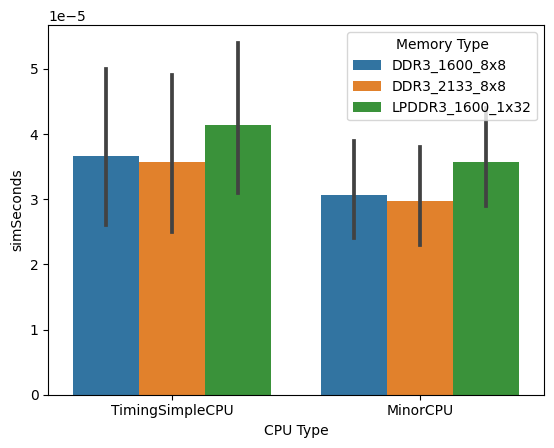

In [8]:
ax = sns.barplot(x="CPU Type", y="simSeconds", hue="Memory Type", data=data)